In [31]:
import torch
import pandas as pd
import numpy as np
#from models.resnetv2 import ResNet50, ResNet101
from models.resnet_attention import resnet50 as resnet50_attention
#from models.resnet_org import resnet50 as resnet50
#from torchvision.models import resnet50, resnet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt

# UTILS

In [32]:
class ResNet50(torch.nn.Module):
    def __init__(self, out_features = 3, freeze = False, in_channels=3):
        super().__init__()
        
        self.out_features = out_features
        self.in_channels = in_channels
        self.backbone = resnet50()
        self.backbone.conv1 = torch.nn.Conv2d(in_channels=self.in_channels, out_channels=64,
                                              kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
        self.backbone.fc = torch.nn.Linear(in_features=2048, out_features=self.out_features, bias=True)
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.backbone.fc.parameters():
                param.requires_grad = True
            for param in self.backbone.conv1.parameters():
                param.requires_grad = True
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [10]:
from utils import stacked_img, iterate_class

# END UTILS

In [11]:
# melanoma model
#!wget -O model_melanoma https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0

In [33]:
path_to_model = '/Users/karol/Desktop/ml3/resnet_att_bias_ckpt_epoch_71.pth'
#path_to_model = '/Users/karol/Desktop/ml3/resnet_bias_ckpt_epoch_49.pth'

In [34]:
#model = ResNet50(out_features = 2, freeze = False, in_channels = 3)
model = resnet50_attention(num_classes = 2)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)
msg1

<All keys matched successfully>

In [35]:
dataset = Melanoma_loader(root = "/Users/karol/melanoma/train/train/", ann_path = "melanoma/data/test_set.csv", 
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [36]:
is_melanoma = 1
generator = iterate_class(dataset, is_melanoma)

model = model.eval()

In [39]:
class AttentionWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)[0]
model = AttentionWrapper(model)

## LRP

In [40]:
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient

In [75]:
test_tensor, path = next(generator)

torch.Size([1, 2048, 64])
shape of x after flattening in gated attention: torch.Size([1, 2048, 64])
shape of A_V in gated attention: torch.Size([1, 2048, 64])
shape of A_U in gated attention: torch.Size([1, 2048, 64])
shape of A after A_V*A_U in gated attention: torch.Size([1, 2048, 1])
shape of x in gated attention: torch.Size([1, 2048, 64])
shape of A in gated attention: torch.Size([1, 2048, 1])
shape of z in gated attention: torch.Size([1, 1, 64])


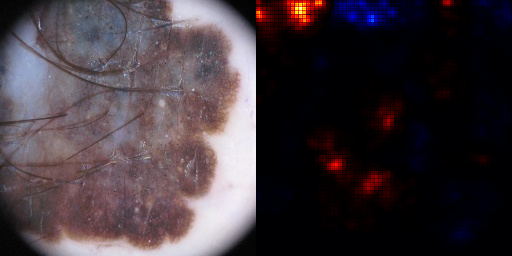

In [87]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# target = torch.eye(2)[[img[1]]] * out[0, 1]
target = torch.eye(2)[[is_melanoma]]
# https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
from zennit.image import imgify
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

LRP explained: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

# CRP

In [88]:
from HackedZennit import get_canonizer
from crp.attribution import CondAttribution
attribution = CondAttribution(model)

In [89]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.eval()


sample, path = next(generator)
sample.requires_grad = True # This is not enough if you have multiple conditions 

In [94]:
print(model.model(sample)[1].argsort()[:,:,:5])

torch.Size([1, 2048, 64])
shape of x after flattening in gated attention: torch.Size([1, 2048, 64])
shape of A_V in gated attention: torch.Size([1, 2048, 64])
shape of A_U in gated attention: torch.Size([1, 2048, 64])
shape of A after A_V*A_U in gated attention: torch.Size([1, 2048, 1])
shape of x in gated attention: torch.Size([1, 2048, 64])
shape of A in gated attention: torch.Size([1, 2048, 1])
shape of z in gated attention: torch.Size([1, 1, 64])
tensor([[[ 905, 1903,  535,  206, 1522]]])


In [92]:
sample

tensor([[[[-1.2103, -1.0904, -1.0219,  ...,  0.5364,  0.4679,  0.4166],
          [-1.1075, -0.9877, -0.9020,  ...,  0.5878,  0.5193,  0.4851],
          [-1.0219, -0.9020, -0.7993,  ...,  0.6734,  0.6049,  0.5707],
          ...,
          [-0.5424, -0.4739, -0.3712,  ...,  0.4166,  0.3652,  0.2967],
          [-0.5938, -0.5424, -0.4568,  ...,  0.3481,  0.3309,  0.2624],
          [-0.6281, -0.5938, -0.5253,  ...,  0.2796,  0.2796,  0.2111]],

         [[-1.1429, -1.0203, -0.9503,  ...,  0.7654,  0.7304,  0.6779],
          [-1.0378, -0.9153, -0.8277,  ...,  0.8179,  0.7829,  0.7479],
          [-0.9503, -0.8277, -0.7227,  ...,  0.9055,  0.8354,  0.8004],
          ...,
          [-0.8803, -0.8102, -0.7052,  ...,  0.1877,  0.1352,  0.0651],
          [-0.9328, -0.8803, -0.7927,  ...,  0.1176,  0.0651, -0.0049],
          [-0.9678, -0.9328, -0.8627,  ...,  0.0476,  0.0126, -0.0574]],

         [[-0.6715, -0.5495, -0.4798,  ...,  1.4897,  1.4374,  1.3851],
          [-0.5670, -0.4450, -

{'model.layer4.2'}
torch.Size([5, 2048, 64])
shape of x after flattening in gated attention: torch.Size([5, 2048, 64])
shape of A_V in gated attention: torch.Size([5, 2048, 64])
shape of A_U in gated attention: torch.Size([5, 2048, 64])
shape of A after A_V*A_U in gated attention: torch.Size([5, 2048, 1])
shape of x in gated attention: torch.Size([5, 2048, 64])
shape of A in gated attention: torch.Size([5, 2048, 1])
shape of z in gated attention: torch.Size([5, 1, 64])


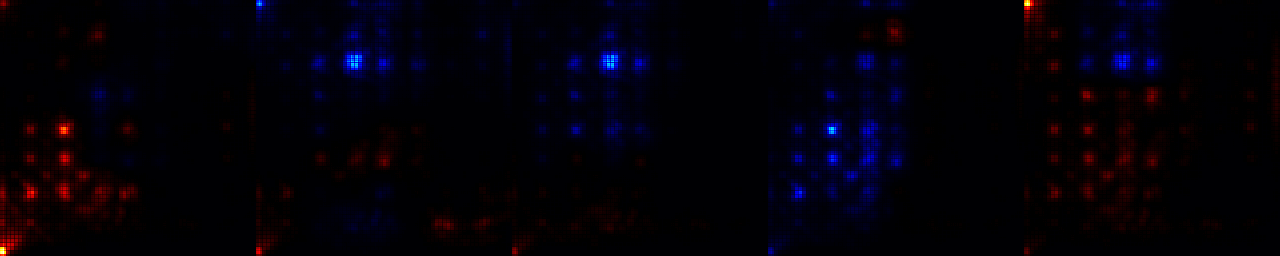

In [95]:
from crp.helper import get_layer_names
from crp.image import imgify

concept_ids = [ 905, 1903,  535,  206, 1522] # those are no of channels which we look at (used to define conditions)
conditions = [{'model.layer4.2.conv3': [ids], 'y': [is_melanoma]} for ids in concept_ids]
# MUST ALWAYS HAVE LINE LIKE ONE BELOW - HACK
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
# - in crp/attribution.py:CondAttribution.__call__ they duplicate data which removes grad requirement from copies
# WORKAROUND: in the __call__ function mentioned above add data.requires_grad = True before self.check_arguments
# or never pass a list of conditions
heatmaps, act, rel, _ = attribution(sample, conditions, composite)
img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)

Those all light blue images are 0 images - these channels have 0 relevance under current parameters.

set()


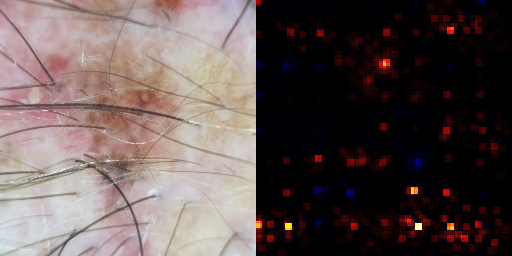

(512, 256)


In [47]:
conditions = [{'y': [is_melanoma]}]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
sample.requires_grad = True
heatmaps, act, rel, _ = attribution(sample, conditions, composite)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
                                                       
new_img = stacked_img(path, img)

display(new_img)
print(new_img.size)

# CRP Concepts

In [48]:
from crp.concepts import ChannelConcept

cc = ChannelConcept()
from crp.helper import get_layer_names

layer_name = 'backbone.layer4.2.conv3'

conditions = [{'y': [is_melanoma]}]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
attr = attribution(sample, conditions, composite, record_layer=[layer_name])

attr.activations[layer_name].shape, attr.relevances[layer_name].shape
# attr[1]["features.40"].shape, attr[2]["features.40"].shape # is equivalent


set()


(torch.Size([1, 2048, 8, 8]), torch.Size([1, 2048, 8, 8]))

In [50]:
rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
#rel_c

tensor([[0.0000e+00, 1.7776e-05, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [19]:
from crp.helper import abs_norm

# the six most relevant concepts and their contribution to final classification in percent
concept_ids = torch.argsort(rel_c[0], descending=True)[:6]
concept_ids, rel_c[0, concept_ids]*100

(tensor([1139,  895, 1679,  715,  565,  167]),
 tensor([2.5896, 2.1817, 1.9479, 1.8323, 1.4779, 1.3434]))

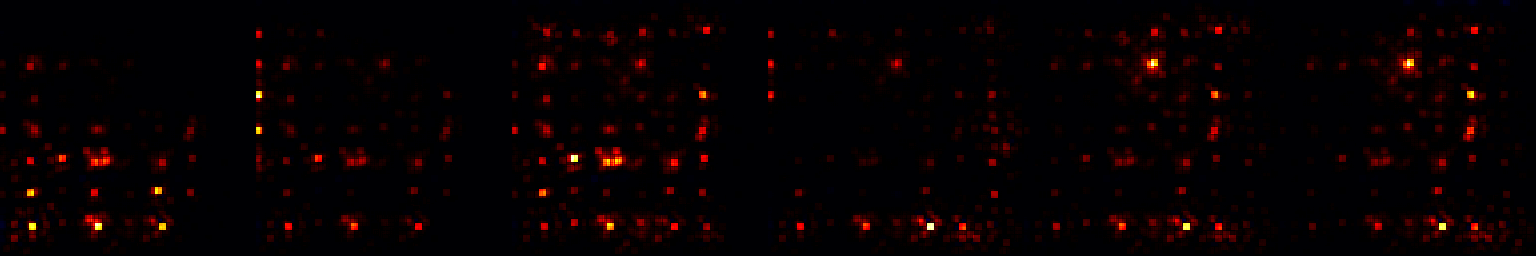

In [20]:
conditions = [{layer_name: [id], 'y': [is_melanoma]} for id in concept_ids]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, cmap='coldnhot', grid=(1, len(concept_ids)))

In [ ]:
plt.rcParams["figure.figsize"] = (40,50)

(256, 256, 3)


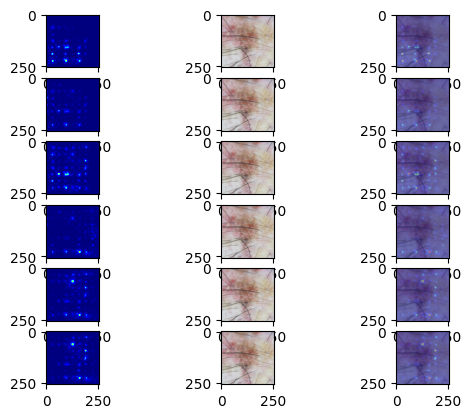

In [22]:
img = np.array(Image.open("/Users/karol/melanoma/train/train/" + path + ".jpg"))
print(img.shape)
# load or compute some features
h, w, _ = img.shape

fig, axs = plt.subplots(6, 3)
for i in range(6):
    feature = np.array(heatmap[i])
    feature = np.clip(feature, 0, 1000)
    feature = (255.5 * feature / np.amax(feature)).astype(np.uint8)
    # compute heated image
    alpha = 0.5; img_feature = ((plt.cm.jet(feature)[:, :, :3] * 255) * alpha + img * (1 - alpha)).astype(np.uint8)
    # show images
    axs[i, 0].imshow(feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
    axs[i, 1].imshow(img)
    axs[i, 2].imshow(img_feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
plt.show()

In [23]:
heatmap.size()

torch.Size([6, 256, 256])

# CRP concepts with mask

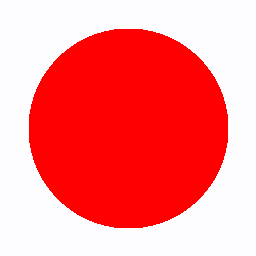

In [25]:
from skimage.draw import disk
mask = torch.zeros(256, 256).to(attribution.device)
row = 128
col = 128
radius = 100
rr, cc = disk((row, col), radius)
mask[rr, cc] = 1

imgify(mask, symmetric=True)


In [26]:
conditions = [{layer_name: [id], 'y': [is_melanoma]} for id in np.arange(0, 2048)]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
rel_c = []
for attr in attribution.generate(sample, conditions, composite, record_layer=[layer_name], batch_size=10):
    
    masked = attr.heatmap * mask[None, :, :]
    rel_c.append(torch.sum(masked, dim=(1, 2)))

rel_c = torch.cat(rel_c)
print(rel_c)
indices = torch.argsort(rel_c, descending=True)[:5]
# we norm here, so that we clearly see the contribution inside the masked region as percentage
indices, abs_norm(rel_c)[indices]*100

100%|██████████| 205/205 [13:58<00:00,  4.09s/it]

tensor([0.0000e+00, 7.6947e-07, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])


(tensor([1139,  715, 1679,  895,  360]),
 tensor([4.0457, 3.3728, 2.6120, 2.4754, 2.3249]))

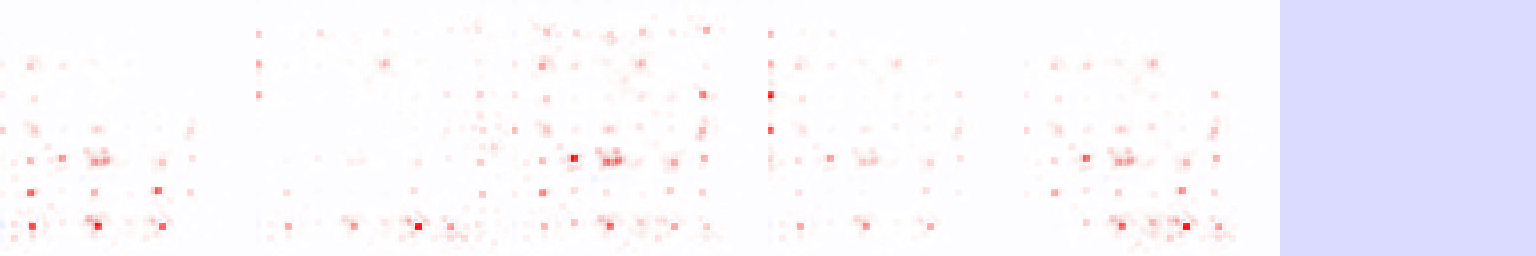

In [27]:
conditions = [{layer_name: [id], 'y': [is_melanoma]} for id in indices]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True,  grid=(1, len(concept_ids)))

(256, 256, 3)


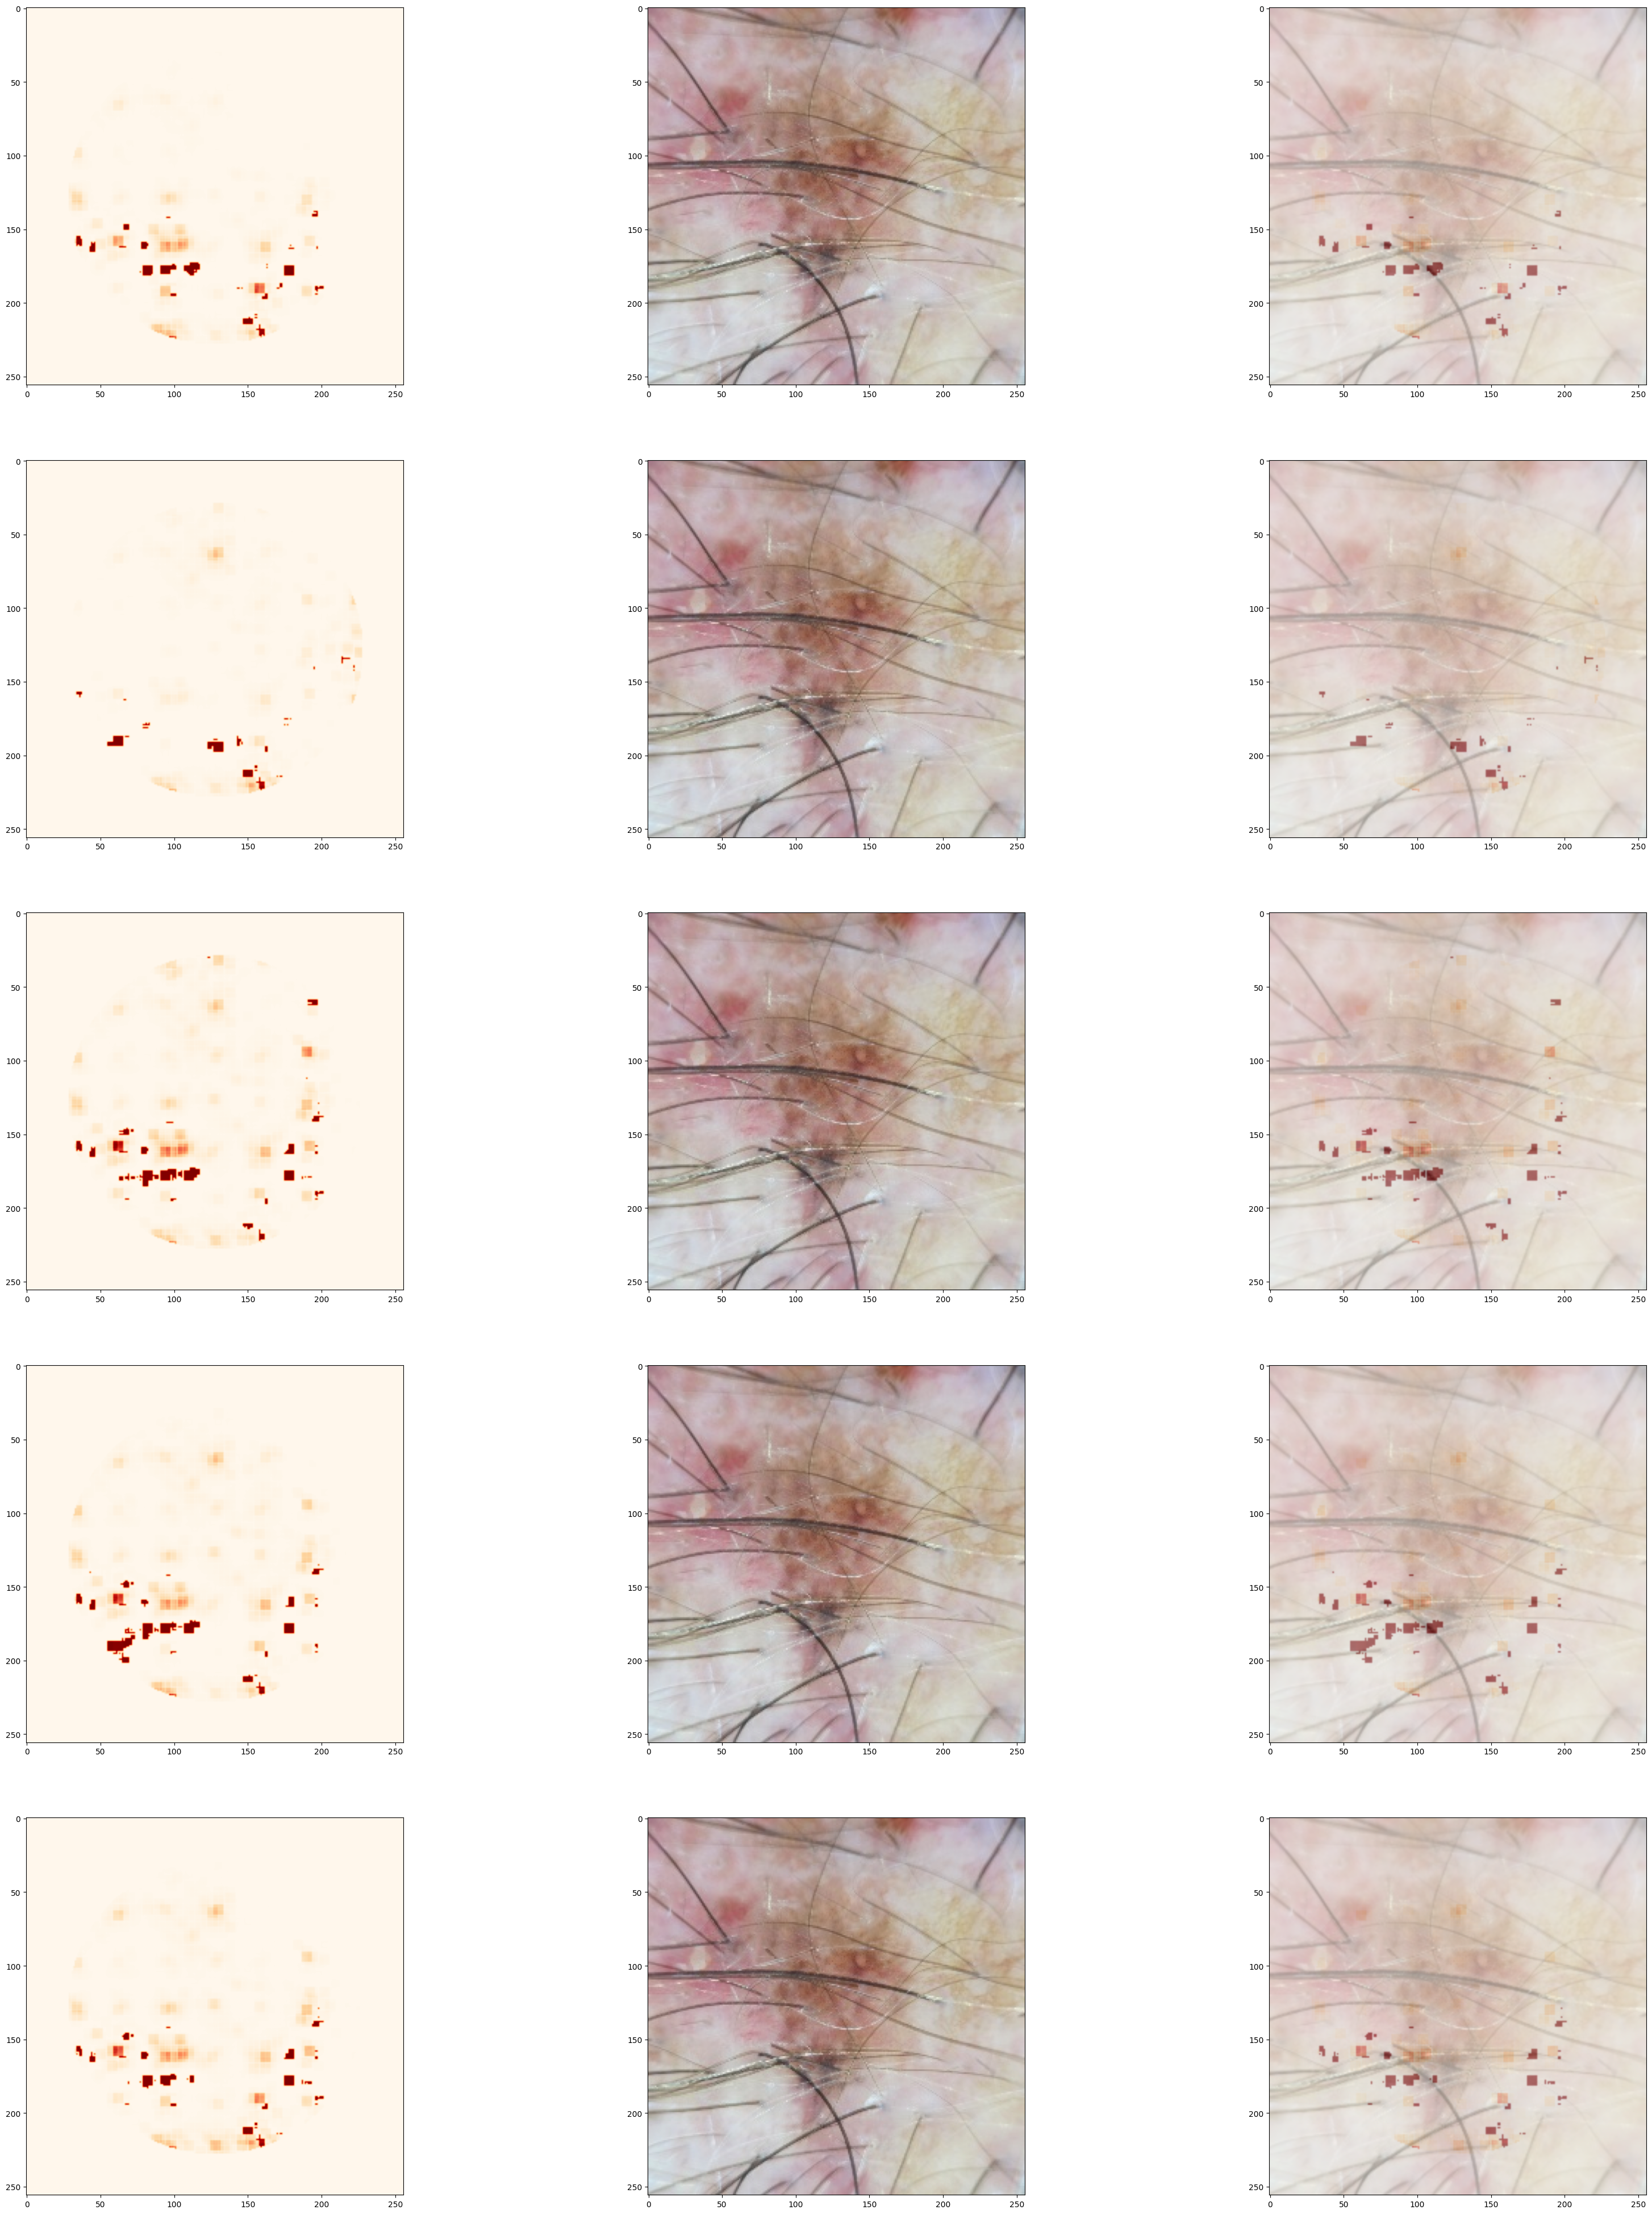

In [32]:
img = np.array(Image.open("/Users/karol/melanoma/train/train/" + path + ".jpg"))
print(img.shape)
# load or compute some features
h, w, _ = img.shape
mg = np.mgrid[:h, :w]

fig, axs = plt.subplots(5, 3)
for i in range(5):
    feature = np.array(heatmap[i] * mask)
    feature = (255.5 * feature / np.amax(feature)).astype(np.uint8)
    # compute heated image
    alpha = 0.5; img_feature = ((plt.cm.OrRd(feature)[:, :, :3] * 255) * alpha + img * (1 - alpha)).astype(np.uint8)
    # show images
    axs[i, 0].imshow(feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.OrRd)
    axs[i, 1].imshow(img)
    axs[i, 2].imshow(img_feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.OrRd)
plt.show()

In [195]:
heatmap.size()

torch.Size([5, 256, 256])

In [196]:
sample.size()

torch.Size([1, 3, 256, 256])